INFO:drake:Meshcat listening for connections at http://localhost:7018


3


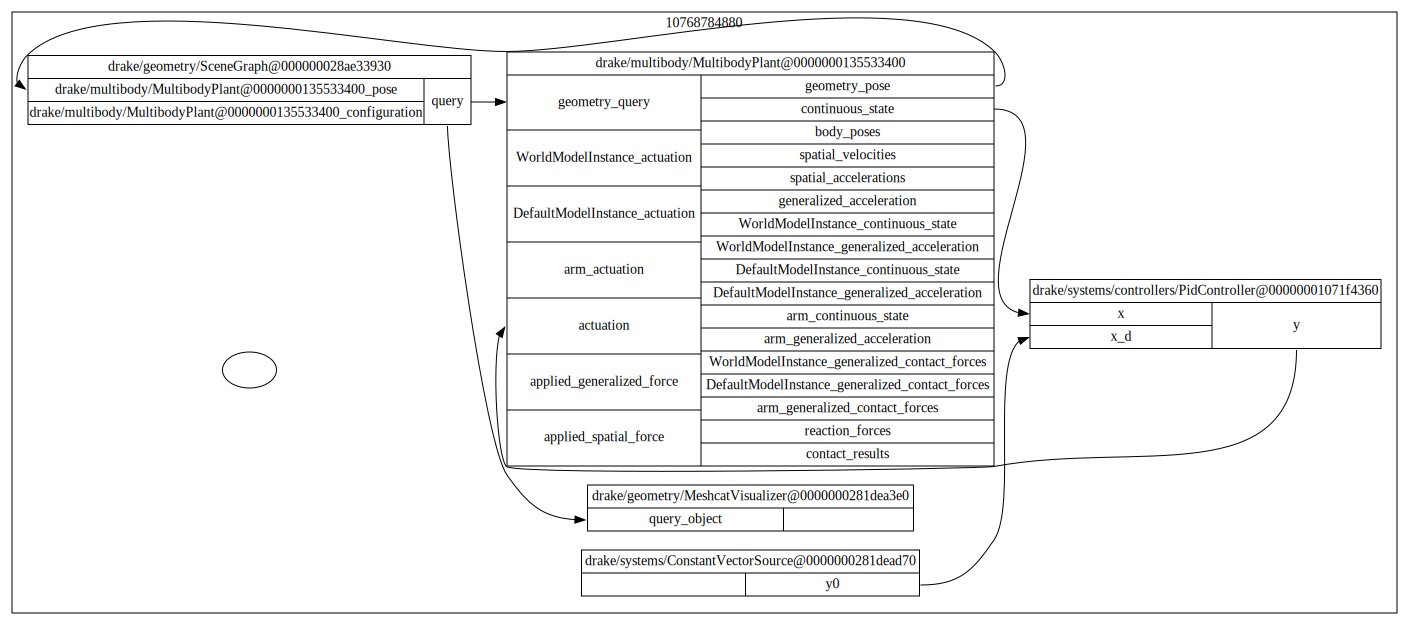

In [1]:
import pydot
import scipy.optimize
from IPython.core.display import SVG
from IPython.core.display_functions import display
from pydrake.all import Simulator, DiagramBuilder, AddMultibodyPlantSceneGraph, \
    Parser, RigidTransform, MeshcatVisualizer, MeshcatVisualizerParams, \
    ConstantVectorSource, ConstantValueSource, PiecewisePolynomial, \
    AbstractValue, HalfSpace, CoulombFriction, SceneGraph, MultibodyPlant, AutoDiffXd, StartMeshcat
from pydrake.systems.controllers import PidController
import numpy as np
import time

from robot import Robot


def f(x, robot, r_des):
    # origin is at arm base (so ground z = -h)
    # y is robot forward, x is robot right, z is up

    theta_r = x[0]
    theta_s = x[1]
    theta_e = x[2]

    L_1 = robot.L_1
    L_2 = robot.L_2

    r_x = (L_1 * np.cos(theta_s) + L_2 * np.cos(theta_s + theta_e)) * np.sin(theta_r)
    r_y = (L_1 * np.cos(theta_s) + L_2 * np.cos(theta_s + theta_e)) * np.cos(theta_r)
    r_z = L_1 * np.sin(theta_s) + L_2 * np.sin(theta_s + theta_e)

    return np.array((r_x, r_y, r_z)) - r_des


def find_arm_trajectory(r_des, q_guess):
    robot = Robot()

    r_guess = robot.r_q(q_guess)

    sol = scipy.optimize.fsolve(f, r_guess, (robot, r_des))

    return sol


target_realtime_rate = 1.0
simulation_time = 10
max_time_step = .0001
Kp_ = 0.5
Ki_ = 0.5
Kd_ = 0.5


def controller(final_state):
    meshcat = StartMeshcat()

    builder = DiagramBuilder()
    scene_graph = builder.AddSystem(SceneGraph())
    plant = builder.AddSystem(MultibodyPlant(0.0))
    plant.RegisterAsSourceForSceneGraph(scene_graph)
    parser = Parser(plant)
    parser.AddModelFromFile("arm.urdf")
    plant.WeldFrames(
        plant.world_frame(),
        plant.GetBodyByName("base_z").body_frame(),
        RigidTransform.Identity()
    )
    plant.AddJointActuator("base", plant.GetJointByName("base"))
    plant.AddJointActuator("shoulder", plant.GetJointByName("shoulder"))
    plant.AddJointActuator("elbow", plant.GetJointByName("elbow"))

    plant.Finalize()

    print(plant.num_positions())

    Kp = np.ones(plant.num_positions()) * Kp_
    Ki = np.ones(plant.num_positions()) * Ki_
    Kd = np.ones(plant.num_positions()) * Kd_

    pid = builder.AddSystem(PidController(Kp, Ki, Kd))

    builder.Connect(plant.get_state_output_port(), pid.get_input_port_estimated_state())

    builder.Connect(pid.get_output_port_control(), plant.get_actuation_input_port())

    desired_base_source = builder.AddSystem(
        ConstantVectorSource(np.reshape(final_state, (6, 1))))
    builder.Connect(desired_base_source.get_output_port(), pid.get_input_port_desired_state())

    # Handled by pydrake
    builder.Connect(plant.get_geometry_poses_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))
    builder.Connect(scene_graph.get_query_output_port(), plant.get_geometry_query_input_port())

    vis_params = MeshcatVisualizerParams(publish_period=0.1)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat, params=vis_params)

    diagram = builder.Build()
    display(SVG(pydot.graph_from_dot_data(
        diagram.GetGraphvizString(max_depth=2))[0].create_svg()))
    diagram_context = diagram.CreateDefaultContext()

    plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)

    positions = np.zeros((plant.num_positions(), 1))

    positions[0] = 3.14 / 2.0
    positions[1] = 3.14 / 2.0
    positions[2] = 3.14 / 2.0

    plant.SetPositions(plant_context, positions)

    simulator = Simulator(diagram)
    simulator.Initialize()
    simulator.set_target_realtime_rate(target_realtime_rate)
    simulator.AdvanceTo(simulation_time)


if __name__ == "__main__":
    r_des = np.array((1, 1, -1))  # where is the trash

    q_guess = np.array([
        -np.pi / 4.0,  # theta_r guess
        -np.pi / 4.0,  # theta_s guess
        -np.pi / 4.0,  # theta_e guess
    ])

    position_final = find_arm_trajectory(r_des, q_guess)
    velocity_final = np.array((0, 0, 0))
    full_final_state = np.append(position_final, velocity_final)

    controller(full_final_state)
